# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [321]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import csv

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [322]:
def get_probs(x):
    x = np.array(x)
    frequencies = np.asarray(np.unique(x, return_counts=True)).T # [[element, n_elemenets], ...]
    cardinal = len(x)
    return np.array(list(map(lambda info : info[1] / cardinal, frequencies)))                     

def gini(x):
    p = get_probs(x)
    return np.sum(p * (1 - p))
    
def entropy(x):
    p = get_probs(x)
    return - np.sum(p * np.log2(p))

def gain(left_y, right_y, criterion):
    n_left = len(left_y)
    n_right = len(right_y)
    n_total = n_left + n_right
    
    return 1 - (n_right / n_total) * criterion(right_y) - (n_left / n_total) * criterion(left_y)

Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [442]:
class DecisionTreeLeaf:
    def __init__(self):
        self.y = None
        self.frequencies = None
        
    def get_probs(self):
        total = sum(f for (_, f) in self.frequencies)
        return {class_name : frequency / total for (class_name, frequency) in self.frequencies}

class DecisionTreeNode(DecisionTreeLeaf):
    def __init__(self, split_dim, split_value, left, right):
        super().__init__()
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.all = None

Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [606]:
def get_most_frequent_class(y):
    frequency = sorted(np.transpose(np.unique(np.array(y), return_counts=True)), key=lambda a: a[1])
    return frequency[-1][0], frequency

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = gini if criterion == "gini" else entropy
        self.max_depth = max_depth if max_depth is not None else float("inf")
        self.node_id = 0
        self.min_samples_leaf = min_samples_leaf
        
    def _train(self, X, y, cur_depth):
        cur_node = None
        if cur_depth > self.max_depth or len(X) <= self.min_samples_leaf:
            cur_node = DecisionTreeLeaf()
            cur_node.y, cur_node.frequencies = get_most_frequent_class(y)
            return cur_node
        max_q, best_dim, best_val, best_left_S, best_right_S = float("-inf"), None, None, None, None
        unique_values_per_dim = [np.sort(np.unique(row)) for row in np.transpose(X)]
        
        for dim, unique in enumerate(unique_values_per_dim):
            if len(unique) == 1:
                continue
            
            split_val = unique[len(unique) // 2]
            left_S = [(x, y_dot) for (x, y_dot) in zip(X, y) if x[dim] < split_val]
            right_S = [(x, y_dot) for (x, y_dot) in zip(X, y) if x[dim] >= split_val]
            
            left_X, left_y = zip(*left_S)
            right_X, right_y = zip(*right_S)
                  
            ratio_left = len(left_X) / len(right_X)
            ratio_right = len(right_X) / len(left_X)
            
            q = gain(left_y, right_y, self.criterion)
            if q > max_q:
                max_q = q
                best_dim = dim
                best_val = split_val
                best_left_S = left_S
                best_right_S = right_S
        
        best_right_X, best_right_y = zip(*best_right_S)
        best_left_X, best_left_y = zip(*best_left_S)
        
        left = self._train(best_left_X, best_left_y, cur_depth + 1)
        right = self._train(best_right_X, best_right_y, cur_depth + 1)
        
        cur_node = DecisionTreeNode(best_dim, best_val, left, right)
        cur_node.y = get_most_frequent_class(y)
        return cur_node
        
    
    def fit(self, X, y):
        X, y = zip(*sorted(zip(X, y)))
        self.root = self._train(X, y, 0)
    
    def predict_proba(self, X):
        return [self._find_leaf(x).get_probs() for x in X]
        
    def _find_leaf(self, x):
        cur_node = self.root
        while isinstance(cur_node, DecisionTreeNode):
            if x[cur_node.split_dim] < cur_node.split_value:
                cur_node = cur_node.left
            else:
                cur_node = cur_node.right
        return cur_node
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [607]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [608]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()


Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

In [609]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier

In [632]:
data_folder = 'homework-decision-tree'

X, y = pd.read_csv(f'./{data_folder}/x_spam_train.csv', index_col=False).drop('Id', axis=1), pd.read_csv(f'./{data_folder}/y_spam_train.csv', index_col=False).drop('Id', axis=1).values.tolist()

boring_columns = 0
for col in X.columns:
    if len(X[col].unique()) == 1:
        X.drop(col, inplace=True,axis=1)
        boring_columns += 1
print(f'Removed {boring_columns} columns')

X = X.values.tolist()     
split_ratio = 1
ds_size = len(X)
assert len(y) == ds_size

p = int(split_ratio * ds_size)
X_train, y_train = X[:p], y[:p]
X_val, y_val = X[p:], y[p:]

Removed 0 columns


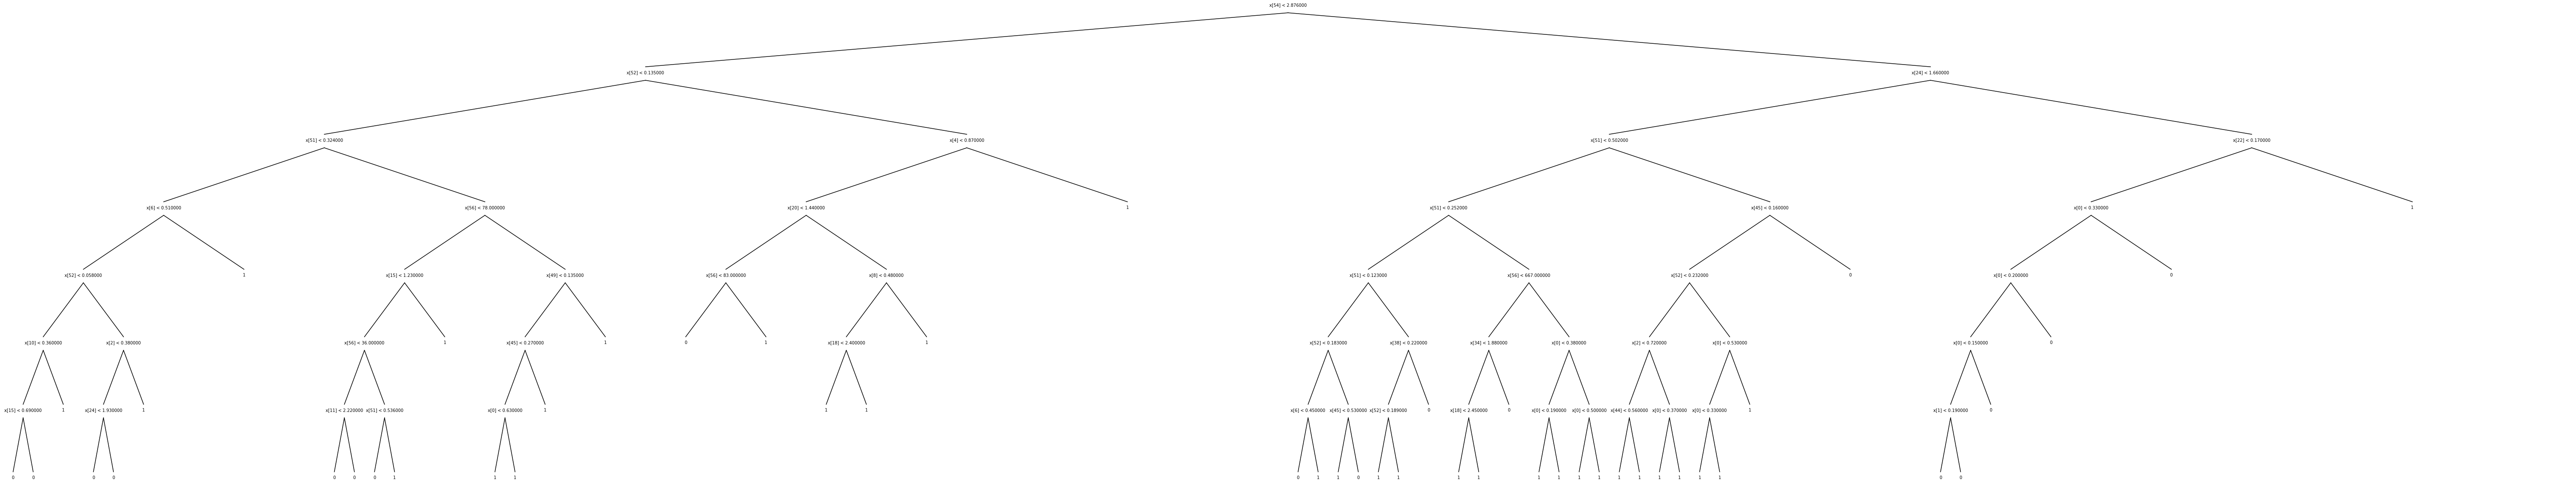

In [633]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, criterion="entropy")
tree.fit(X_train, y_train)
draw_tree(tree)

In [634]:
plot_roc_curve(np.squeeze(y_val), tree.predict_proba(X_val))

ZeroDivisionError: division by zero

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [635]:
X_test = pd.read_csv(f'./{data_folder}/x_spam_test.csv', index_col=False)

submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = X_test["Id"]
submission["Expected"] = tree.predict(X_test.drop('Id', axis=1).values.tolist())
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,Expected
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
